In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os
import matplotlib.pyplot as plt
try:
	import gadget
except:
	print('couldnt import gadget!')
import numpy as np
import Param as param
import FigureMove as Fig
import auxiliary_functions as aux
import importlib
importlib.reload(aux)
importlib.reload(Fig)

## Gaussian 2D

In [ ]:
def getFunctionY(x, y, sigma):
    return 1/(2*np.pi*sigma**2)*np.exp(-(x**2+y**2)/(2*sigma**2))
def getFunction(x, y, sigma):
    return np.array([x,y]), getFunctionY(x, y, sigma)
def getFTFunction(nu, mu, sigma):
    ks = np.sqrt(nu**2+mu**2).flatten()
    args = np.argsort(ks)
    ks = ks[args]
    y = np.array(1/(2*np.pi)*np.exp(-(nu**2+mu**2)*sigma**2/(2))).flatten()
    y = y[args]
    return ks, y 

$P(x,y)=\frac{1}{2\pi\sigma^2}\exp\left[-\frac{x^2+y^2}{2\sigma^2}\right] \\
\hat{P}(\nu,\mu)=\frac{1}{2\pi}\exp\left[-\sigma^2\frac{\nu^2+\mu^2}{2}\right]$

In [ ]:
functionReal = lambda x,p: getFunction(*x, *p)
functionFourier = lambda x,p: getFTFunction(*x, *p)

In [ ]:
def doFFTnD(D=2, n=1000, n_pad=0, delta=1, constants = [5e-10, 26., 0.67], realFT=True):
    import collections
    def checkParas(para, name):
        if not isinstance(para, collections.Iterable):
            para = [para for i in range(D)]
        if np.size(para)<D:
            print(name, para)
            raise Exception('need more information for %sx, %sy, ...' %(name,name))
        return para
    def x1(n ,n_pad, delta):
        return (-(n+n_pad)/2 + 1)*delta
    n = checkParas(n, 'n')
    n_pad = checkParas(n_pad, 'n_pad')
    delta = checkParas(delta, 'delta')
    print('n,n_pad,delta',n,n_pad,delta)
#     x1 = (-(n+n_pad)/2 + 1)*deltax;
    mesh = np.meshgrid(*(np.arange(x1(n[i] ,n_pad[i], delta[i]), x1(n[i] ,n_pad[i], delta[i])+(n[i]+n_pad[i])*delta[i], delta[i]) for i in range(D)))
    MaxX = np.max([x for X in [m.flatten() for m in mesh] for x in X])
#     MaxX = grid[-1]-grid[0]
    spacing = deltax
    print('Max value x direction', MaxX)
    print('Spacing x values', MaxX)
    print(constants)
    grid, samples = functionReal(mesh, constants)
    if not realFT:
        factorGrid = np.meshgrid(*(np.arange(0, n[i]+n_pad[i]) for i in range(D)))
        factor = np.array([np.sqrt(n[i]/(2*np.pi))*delta[i]*np.exp(-2*np.pi*np.complex(0,1)*x1(n[i] ,n_pad[i], delta[i])/(n[i]*delta[i])*np.array(factorGrid[i], dtype=np.complex)) for i in range(D)])
        factor = np.prod(factor ,axis=0)
        transform = np.fft.fftn(samples, norm='ortho') * factor
        ksSep = np.array(np.meshgrid(*(np.fft.fftfreq(n[i]+n_pad[i], d = delta[i])*2*np.pi for i in range(D))) )                                         
        ks = np.sqrt(np.sum(ksSep**2 ,axis=0))
    else:
        factorGrid = np.meshgrid(*(np.arange(0, (n[i]+n_pad[i])/2+1) if i==0 else np.arange(0, n[i]+n_pad[i]) for i in range(D)))
        factor = np.array([np.sqrt(n[i]/(2*np.pi))*delta[i]*np.exp(-2*np.pi*np.complex(0,1)*x1(n[i] ,n_pad[i], delta[i])/(n[i]*delta[i])*np.array(factorGrid[i], dtype=np.complex)) for i in range(D)])
        factor = np.prod(factor ,axis=0)
        transform = np.fft.rfftn(samples, norm='ortho') * factor
        ksSep = np.array(np.meshgrid(*(np.fft.rfftfreq(n[i]+n_pad[i], d = delta[i])*2*np.pi if i==0 else np.fft.fftfreq(n[i]+n_pad[i], d = delta[i])*2*np.pi for i in range(D))) )                                         
        ks = np.sqrt(np.sum(ksSep**2 ,axis=0))
    return ks.flatten(), transform.flatten(), MaxX, spacing, functionFourier(ksSep,constants), constants, mesh

In [ ]:
Colors = ['#7ca2df','#2565ca','#0e2850','#bb596d','#9F132F','#4f0917','#ffd27f','#FFA500','#664200']
Markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#sigma, mu, a, b
n = 1000
N_pad = [0]#[0,n]
skipN = 70
deltax = 100. / n
fig = plt.figure(figsize=np.array([10,6]))
ax = plt.axes([0.15,0.15,0.8,.8])
a, b, c = 5e-10, 26., 1
a, b, c = 5.1542501e-06, 5.0000000e+01, 4.0000000e-01
Constants = [[14]]#, [a, b, 2]]
Nloop = 0
for constants,c in zip(Constants, Colors):
    for marker, n_pad in zip(Markers, N_pad):
        print('Nloop:', Nloop)
        ks, transform, MaxX, spacing, anaFT, constants, grid = doFFTnD(n=n, n_pad=n_pad, delta=deltax, constants = constants, realFT=True)
        print('ks',ks)
        print('transform',transform)
        print('MaxX',MaxX)
        print('spacing',spacing)
        print('anaFT',anaFT)
        print('constants',constants)
        
        print(np.shape(ks))
        print(np.shape(transform))
        print(np.shape(anaFT))
        ax.plot(abs(anaFT[0])/(2*np.pi), abs(anaFT[1])**2*(anaFT[0]/(2*np.pi))**2, c='gray', label='analytical')
        ks, transform, err = Fig.do_Radprof(ks,transform,weight=None,range=[None,None],log=False,NBins=100,typeCalc='average',errbar=None, return_binedges=False, SameNumberPointsPerBin=False)
        ax.scatter(*[x if index == 1 else x/(2*np.pi) for index,x in enumerate(np.array([ks,abs(transform)**2*(ks/(2*np.pi))**2]))], c='red', marker='x', label='num real $\sigma=$%g, n_pad: %i' %(constants[-1], n_pad))
        ks, transform, MaxX, spacing, anaFT, constants, grid = doFFTnD(n=n, n_pad=n_pad, delta=deltax, constants = constants, realFT=False)
        ax.scatter(*[x[::skipN] if index == 1 else x[::skipN]/(2*np.pi) for index,x in enumerate(np.array([ks,abs(transform)**2*(ks/(2*np.pi))**2]))], alpha=0.5, c=c, marker=marker, label='num all $\sigma=$%g, n_pad: %i' %(constants[-1], n_pad))
        Nloop += 1
    Nloop += 1

plt.axvline(x=2*np.pi/spacing/2, label=r'$2\pi/(2\Delta x)$', c='grey', ls='--')#can probe scales 2*dx
# plt.axvline(x=2*np.pi/spacing/8, label=r'$2\pi/(4\Delta x)$', c='grey', ls=':')#can probe scales 2*dx
# plt.axvline(x=0.5, label=r'pad ok', c='grey')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k/2\pi$')
ax.set_ylabel('g(k)')
# ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

# fig.canvas.draw()
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels = ['%s'%(2*np.pi/float(l)) for l in labels if float(l)!=0]
# ax.set_xticklabels(labels)
ax.set_ylim([1e-27,1e-2])
plt.legend(loc='center left', framealpha=.8, fancybox=True, bbox_to_anchor=(1,0.5))

fig.savefig('TestingFourierAnalyticsPressureProfileGXPython.pdf', dpi=450)


fig = plt.figure()
ax1 = plt.axes([0.15,0.15,0.8,.8])
# print(grid[grid>0])
for constants in Constants:
#     print(functionReal(grid,constants))
    print([np.sqrt(np.sum(x**2, axis=0)).flatten() if index==0 else x.flatten() for index,x in enumerate(functionReal(grid,constants))][0])
    print([np.sqrt(np.sum(x**2, axis=0)).flatten() if index==0 else x.flatten() for index,x in enumerate(functionReal(grid,constants))][1])
    ax1.scatter(*(np.sqrt(np.sum(x**2, axis=0)).flatten() if index==0 else x.flatten() for index,x in enumerate(functionReal(grid,constants))) , label='%g' %constants[-1])
ax1.set_ylim([1e-20,1e2])
ax1.set_xscale('log')
ax1.set_yscale('log')
plt.legend(loc='center left', framealpha=.8, fancybox=True, bbox_to_anchor=(1,0.5))

plt.show()

In [ ]:
snap.data['DistInKpc'], snap.data['SqrtEpsB']
def doRealDataFFT(n=1000, n_pad=0, deltax=1, constants = [5e-10, 26., 0.67], realFT=True):
    x1 = (-(n+n_pad)/2 + 1)*deltax;
    grid = np.concatenate((np.arange(x1, x1+(n)*deltax, deltax),np.zeros((n_pad))))
    grid = np.arange(x1, x1+(n+n_pad)*deltax, deltax)
    MaxX = np.max(grid)
    MaxX = grid[-1]-grid[0]
    spacing = deltax
    print('Max value x direction', MaxX)
    print('Spacing x values', MaxX)
    print(constants)
    grid, samples = functionReal(grid, constants)
    if not realFT:
        factor = np.sqrt(n/(2*np.pi))*deltax*np.exp(-2*np.pi*np.complex(0,1)*x1/(n*deltax)*np.arange(0, n+n_pad))
        print('shape factor: ', np.shape(factor), 'shape samples: ', np.shape(samples))
        transform = np.fft.fft(samples, norm='ortho') * factor
        ks = np.fft.fftfreq(n+n_pad, d = deltax)*2*np.pi
    else:
        factor = np.sqrt(n/(2*np.pi))*deltax*np.exp(-2*np.pi*np.complex(0,1)*x1/(n*deltax)*np.arange(0, (n+n_pad)/2+1))
        print('shape factor: ', np.shape(factor), 'shape samples: ', np.shape(samples))
        transform = np.fft.rfft(samples, norm='ortho') * factor
        ks = np.fft.rfftfreq(n+n_pad, d = deltax)*2*np.pi        
    return ks, transform, MaxX, spacing, abs(functionFourier(ks,constants)[1]), constants, grid

In [163]:
import scipy.special
def phi(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-1/2.*x**2)
def Phi(x):
    return 1/2.*(1+scipy.special.erf(x/np.sqrt(2)))
def getFunction(x, mu, sigma, a, b):
    return x, phi((x-mu)/sigma)/(sigma*(Phi((b-mu)/sigma)-Phi((a-mu)/sigma)))
def getFTFunction(ks, mu, sigma, a, b):
    return ks, np.exp(np.complex(0,1)*mu*ks-sigma**2*ks**2/2)/(np.sqrt(2*np.pi)*np.sqrt(1/(sigma**2))*sigma*(1/2.*(-1-scipy.special.erf((a-mu)/(np.sqrt(2)*sigma)))+1/2.*(1+scipy.special.erf((b-mu)/(np.sqrt(2)*sigma)))))

NameError: name 'f1D' is not defined

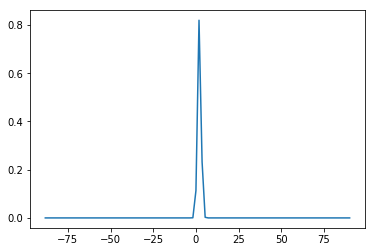

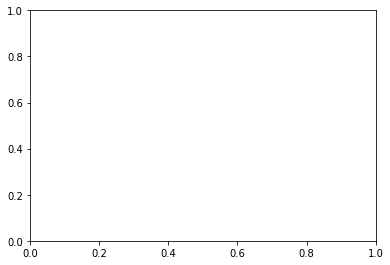

In [164]:
functionReal = lambda x,p: getFunction(x, *p)
functionFourier = lambda x,p: getFTFunction(x, *p)
constants = [5e-10, 26., 0.73]
constants = [2, 1, 2, 4]
n = 100
n_pad = 0
deltax = 1.8; #1e3/float(n+n_pad)
x1 = 0;
x1 = (-(n+n_pad)/2 + 1)*deltax;
grid = np.arange(x1, x1+(n+n_pad)*deltax, deltax)
# print(grid)
grid, samples = functionReal(grid, constants)
# samples[n_pad/2:n+n_pad/2]
# [0]*int(n_pad/2)+list(np.array(samples)[int(n_pad/2):int(n+int(n_pad/2))])+[0]*int(n_pad/2)
#samples = np.array([0]*int(n_pad/2+1)+list(np.array(samples)[int(n_pad/2):int(n+int(n_pad/2))-1])+[0]*int(n_pad/2))
# samples = np.array([0]*int(n_pad)+list(np.array(samples)[n:]))
# print(np.size(samples[samples!=0]),np.size(samples[samples==0]))
# print(samples)
# print(samples)
factorNeg = np.sqrt(n/(2*np.pi))*deltax*np.exp(-2*np.pi*np.complex(0,1)*x1/(n*deltax)*np.arange(0, n_pad+n))
factor = np.sqrt(n/(2*np.pi))*deltax*np.exp(-2*np.pi*np.complex(0,1)*x1/(n*deltax)*np.arange(0, n+n_pad))
factorSimpl = np.sqrt(n/(2*np.pi))*deltax

transform = np.fft.fft(samples, norm='ortho') *factor #fft/sqrt(n)*sqrt(n)*L/n
freq = np.fft.fftfreq(n+n_pad, d = deltax)*2*np.pi

# np.sqrt(n/(2.*np.pi)*deltax**2), abs(factor), 
plt.plot(*functionReal(grid,constants))
import matplotlib.pyplot as plt
plt.figure()
ax = plt.axes([0.1,0.1,0.8,.8])
ax.plot(ks, abs(f1D)**1)
ax.scatter(*np.array([freq,abs(transform)**1]))

In [ ]:

# plt.hist((functionFourier(freq,constants)[1]/(transform+functionFourier(freq,constants)[1])*2).real,bins=100)
# plt.axvline(x=1,color='red',alpha=0.4)
alpha=0.5
plt.plot(freq,functionFourier(freq,constants)[1].real/transform.real,'x',alpha=alpha,label='factor pos',color='black')
plt.plot(freq,functionFourier(freq,constants)[1].real/(transform.real/factor.real*factorNeg.real),'>',alpha=alpha,label='factor neg')
plt.plot(freq,functionFourier(freq,constants)[1].real/(transform.real/factor.real*factorSimpl),'D',alpha=alpha,label='simple fac')
plt.plot(freq,[1]*np.size(freq),label=1)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylim([1e-1,1e2])
grid;

In [ ]:
# transform = np.fft.fft(samples) /np.sqrt(n)*factor
# freq = np.fft.fftfreq(n, d = deltax)*2*np.pi
# plt.hist((functionFourier(freq,constants)[1]/(transform+functionFourier(freq,constants)[1])*2).real,bins=100)
# plt.axvline(x=1,color='red',alpha=0.4)
alpha=0.5
plt.plot(freq,abs(functionFourier(freq,constants)[1]/abs(transform)),'x',alpha=alpha,label='factor pos',color='black')
plt.plot(freq,abs(functionFourier(freq,constants)[1]/(transform/factor*factorNeg)),'>',alpha=alpha,label='factor neg')
plt.plot(freq,abs(functionFourier(freq,constants)[1]/(transform/factor*factorSimpl)),'D',alpha=alpha,label='simple fac')
plt.plot(freq,[1]*np.size(freq),label=1)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylim([1e-1,1e1])

In [ ]:
ks, f1D = functionFourier(abs(freq), constants)

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
ax = plt.axes([0.1,0.1,0.8,.8])
ax.plot(ks, KpcInCm**1*abs(f1D)**1*ks**1)
ax.scatter(*np.array([freq, KpcInCm**1*freq**1*abs(transform)**1]))
# plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\ [\mathrm{kpc}^{-1}]$')
plt.ylabel(r'$k\ \hat{P^2}\ [G^2\ \mathrm{cm}^{-1}]$')
plt.figure()
ax = plt.axes([0.1,0.1,0.8,.8])
ax.plot(ks, abs(f1D)/abs(transform))
ax.plot(ks, abs(ks)/abs(freq))
plt.xscale('log')
#ax.scatter(*np.array([freq, KpcInCm**1*freq**1*abs(transform)**1]))
# plt.show()

## 3D

In [ ]:
import numpy as np
import auxiliary_functions as aux

In [ ]:
def getFunction(x, y, z):
    return np.sqrt(x**2+y**2+z**2), np.exp(-(x**2+y**2+z**2))
def getFourierFunction(kx, ky, kz):
    return np.sqrt(kx**2+ky**2+kz**2), (1./(2*np.sqrt(2)))*np.exp(-(kx**2+ky**2+kz**2)/4)

In [ ]:
# functionReal = lambda x,p: getFunction(x, *p)
# functionFourier = lambda x,p: getFourierFunction(x, *p)
functionReal = lambda x: getFunction(*x)
functionFourier = lambda x: getFourierFunction(*x)
# constants = [5e-10, 26., 0.73]
n = 100;
NDim = 3
KpcInCm = 1.#3.086e21
deltax = 10**(2)/float(n);
x1 = 0;
x1 = (-n/2 + 1)*deltax;
grid = np.arange(x1, x1+(n)*deltax, deltax)
grid = np.meshgrid(grid,grid,grid)
gridPlot, samples = functionReal(grid)
factor = np.sqrt(n/(2*np.pi))*np.exp(2*np.pi*np.complex(0,1)*x1/(n*deltax)*np.arange(0, n))*deltax
factor = np.meshgrid(factor,factor,factor)
factor = factor[0]*factor[1]*factor[2]
print(np.sort(gridPlot.flatten()))

$n=200 \\
\delta_x=\frac{10^3}{n} \\
x_1=\left(-\frac{n}{2}+1\right)\delta_x \\
x = x_1,\ x_1+(1)\delta_x,\ x_1+(2)\delta_x+,\ ...,\ +(n-1)\delta_x \\
samples = function(x) \\
fac = \sqrt{\frac{n}{2\pi}}\exp\left(\frac{2\pi i x_1}{n \delta_x}\ \left(0,\ 1,\ ...,\ n-1\right)\right) \delta_x \sqrt{\frac{n}{2\pi}}\exp\left(\frac{2\pi i x_1}{n \delta_y}\ \left(0,\ 1,\ ...,\ n-1\right)\right) \delta_y
\sqrt{\frac{n}{2\pi}}\exp\left(\frac{2\pi i x_1}{n \delta_z}\ \left(0,\ 1,\ ...,\ n-1\right)\right) \delta_z\\
$

In [ ]:
transform = np.fft.fftn(samples)*factor /np.sqrt(n)**NDim
transformNoFac = np.fft.fftn(samples) /np.sqrt(n)**NDim #*factor
freq = np.fft.fftfreq(n, d = deltax)*2*np.pi
gridFreq = np.meshgrid(freq,freq,freq)
freqAna, transformAna = functionFourier(gridFreq)
# print(np.shape(samples),np.shape(factor))
#factor = np.sqrt(n/(2*np.pi))*np.exp(2*np.pi*np.complex(0,1)*x1/(n*deltax)*np.arange(0, n))*deltax

In [ ]:
import scipy.stats
MIN = np.min(abs(freqAna)[abs(freqAna)>0])
MAX = np.max(abs(freqAna))
binN = 30
BINS = 10**np.linspace(np.log10(MIN), np.log10(MAX), binN)
RadProf, bin_edges, binnumber = scipy.stats.binned_statistic(freqAna.flatten(),
                                np.abs(transform.flatten()), statistic='mean', bins=BINS,range=[MIN,MAX])
RadProf = np.nan_to_num(RadProf)
bin_centers = bin_edges[0] + np.diff(bin_edges)/2.

In [ ]:
import scipy.stats
MIN = np.min(abs(freqAna)[abs(freqAna)>0])
MAX = np.max(abs(freqAna))
binN = 30
BINS = 10**np.linspace(np.log10(MIN), np.log10(MAX), binN)
RadProfNoFac, bin_edges, binnumber = scipy.stats.binned_statistic(freqAna.flatten(),
                                np.abs(transformNoFac.flatten()), statistic='mean', bins=BINS,range=[MIN,MAX])
RadProfNoFac = np.nan_to_num(RadProfNoFac)
bin_centersNoFac = bin_edges[0] + np.diff(bin_edges)/2.

In [ ]:
import scipy.stats
MIN = np.min(abs(freqAna)[abs(freqAna)>0])
MAX = np.max(abs(freqAna))
binN = 30
BINS = 10**np.linspace(np.log10(MIN), np.log10(MAX), binN)
RadProfAna, bin_edgesAna, binnumber = scipy.stats.binned_statistic(freqAna.flatten(),
                                np.abs(transformAna.flatten()), statistic='mean', bins=BINS,range=[MIN,MAX])
RadProfAna = np.nan_to_num(RadProfAna)
bin_centersAna = bin_edgesAna[0] + np.diff(bin_edgesAna)/2.

$
\hat{x}=\frac{\mathrm{FT}(samples*fac)}{\sqrt{n}}
$

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
ax = plt.axes([0.1,0.1,0.8,.8])
ax.scatter(bin_centers, abs(RadProf)**1, marker='x', alpha=0.5, label='numerical')
ax.scatter(bin_centersNoFac, abs(RadProfNoFac)**1, marker='x', alpha=0.5, label='numerical, no fac')
ax.scatter(*np.array([bin_centersAna, abs(RadProfAna)**1]), marker='d',color='red', alpha=0.5, label='analytical')
# ax1 = plt.subplot(311)
# ax1.scatter(bin_centers, abs(RadProf)**1)
# ax2 = plt.subplot(312)
# ax2.scatter(*np.array([bin_centersAna, abs(RadProfAna)**1]), color='red')
# ax2 = plt.subplot(313)
# ax2.scatter(*np.array([bin_centersAna, abs(RadProfAna)**1]), color='red')
Xmin=np.min([np.min(bin_centers), np.min(bin_centersAna)])
Xmax=np.max([np.max(bin_centers), np.max(bin_centersAna)])
try:
    Ymin=np.min([np.min(RadProf[RadProf>0]), np.min(RadProfAna[RadProfAna>0])])
except:
    Ymin=None
Ymax=np.max([np.max(RadProf), np.max(RadProfAna)])
for ax in [ax]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$k\ [\mathrm{kpc}^{-1}]$')
    ax.set_ylabel(r'$k\ \hat{P^2}\ [G^2\ \mathrm{cm}^{-1}]$')
    ax.set_xlim([Xmin,Xmax])
    ax.set_ylim([1e-18,1e1*Ymax])
print(Xmin,Xmax,Ymin,Ymax)
# plt.xlim([Xmin,Xmax])
# plt.ylim([Ymin,Ymax])
plt.legend()

plt.figure()
ax = plt.axes([0.1,0.1,0.8,.8])
ax.scatter(bin_centers, abs(RadProfNoFac)**1/abs(RadProf)**1, marker='x', alpha=0.5, label='no fac/ fac')

plt.show()
bin_centers